In [1]:
from microstructpy.markets.continous import ContinousOrderBookMarket
from microstructpy.traders.noise import NoiseTrader
from microstructpy.traders.market_maker import MarketMaker, BayesianMarketMaker
from microstructpy.traders.informed import InformedTrader, TWAPTrader
from microstructpy.traders.ensemble import ensemble_traders
from microstructpy.visualization.summary import participant_comparison, price_path
from microstructpy.metrics.trader_metrics import *
from microstructpy.metrics.market import *

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def noise_volume():
    return np.random.normal(5, 5)

In [3]:
market = ContinousOrderBookMarket()
liq_trader  = NoiseTrader(market, submission_rate=1, volume_size=lambda: np.random.normal(5, 5))
dealer      = BayesianMarketMaker(market, initial_fair_value=100, spread = 6, max_inventory=100)
inf_trader =  TWAPTrader(market, position_target=500, target_price=120)

In [4]:
background_mm_params = {'initial_fair_value': [100]*5, 
                 'spread': list(range(6, 11)),
                 'market': [market]*5,
                 'max_inventory': np.arange(200, 700, 100)}
background_mm = ensemble_traders(BayesianMarketMaker, background_mm_params)

In [5]:
market.run(2000)

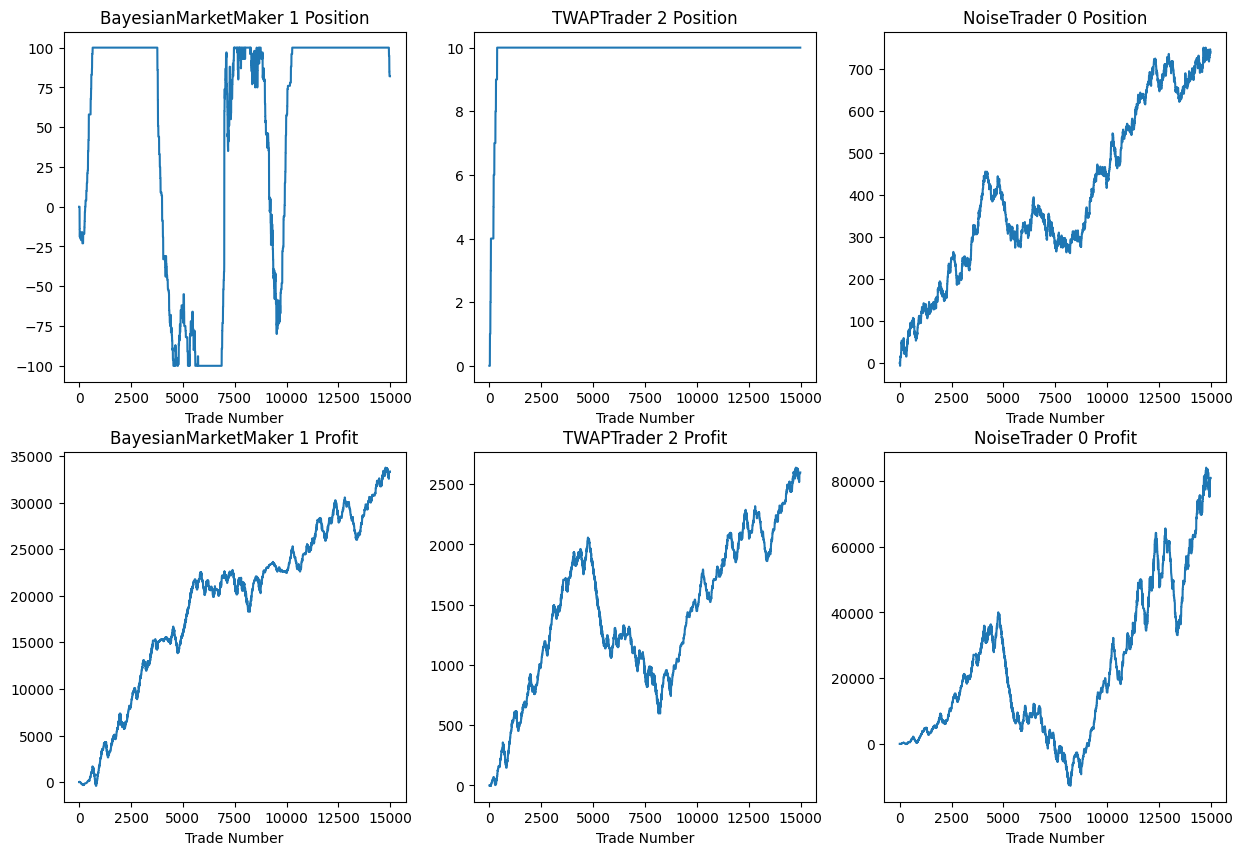

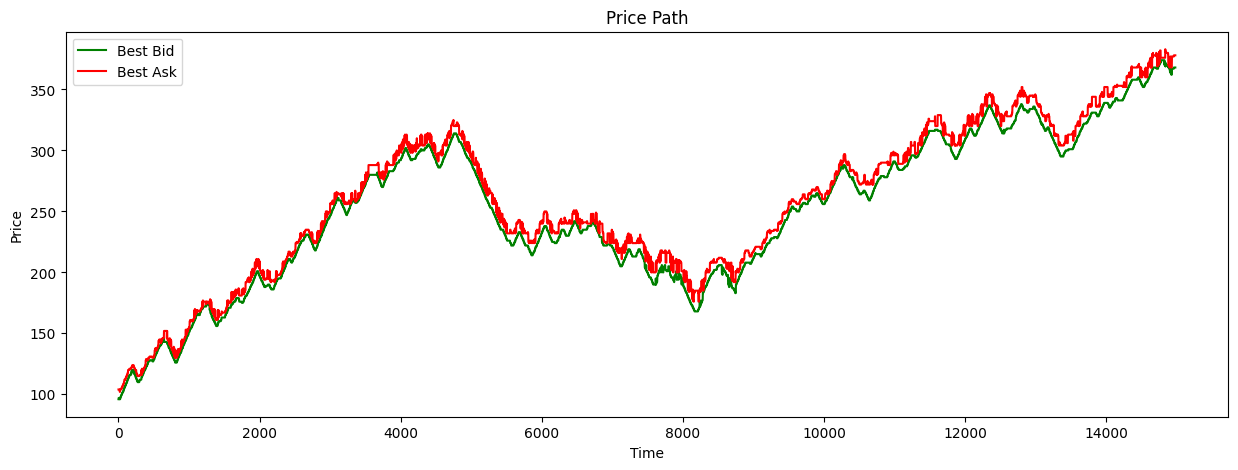

In [6]:
participant_comparison(market.participants)
price_path(market)

<Axes: xlabel='time'>

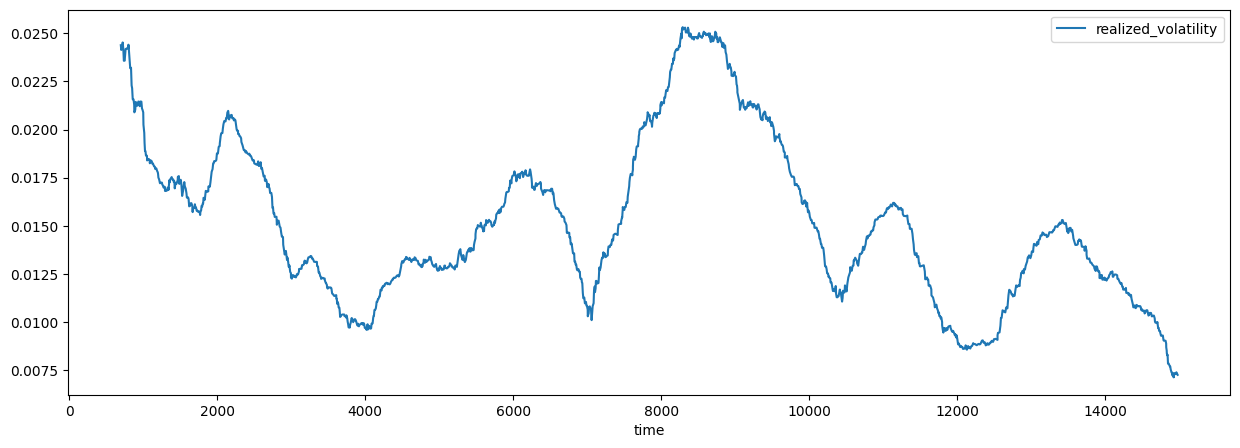

In [7]:
realized_volatility(market).plot(figsize=(15,5))